In [41]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

def load_brain_mri_data(data_dir, batch_size=32, train_split=0.8):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)


    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3), 
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])

    valid_extensions = ('.tif', '.tiff', '.png', '.jpg', '.jpeg', '.bmp')

    dataset = datasets.ImageFolder(
        root=data_dir,
        transform=transform,
        is_valid_file=lambda x: x.lower().endswith(valid_extensions)
    )

    if len(dataset) == 0:
        raise ValueError("No valid image files found. Check file extensions and folder structure.")
    train_size = int(train_split * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    print(f"Total samples: {len(dataset)}")
    print(f"Train set: {len(train_dataset)}")
    print(f"Test set: {len(test_dataset)}")
    print(f"Classes: {dataset.classes}")

    return train_loader, test_loader, device, dataset.classes


In [42]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# Confirm folder structure
data_dir = r"C:\Users\jetwi\Downloads\brain_mri_data"
if not os.path.isdir(os.path.join(data_dir, "yes")) or not os.path.isdir(os.path.join(data_dir, "no")):
    raise ValueError(f"Expected subfolders 'yes' and 'no' in {data_dir}, but they were not found.")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU Detected:", torch.cuda.get_device_name(0))
else:
    print("GPU not available. Training will be slower.")

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # ResNet needs 3-channel input
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])

])

# Define dataset
valid_extensions = ('.tif', '.tiff', '.png', '.jpg', '.jpeg', '.bmp')
dataset = datasets.ImageFolder(
    data_dir,
    transform=transform,
    is_valid_file=lambda x: x.lower().endswith(valid_extensions)
)

if len(dataset) == 0:
    raise ValueError("No valid image files found. Make sure 'yes/' and 'no/' contain images.")

# Split into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=2)

# Build model
def build_model(base_model):
    for param in base_model.parameters():
        param.requires_grad = True  # Fine-tune all layers
    base_model.fc = nn.Sequential(
        nn.Linear(base_model.fc.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, 1),
        nn.Sigmoid()
    )
    return base_model.to(device)

# Training function
def train_model(model, name):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 10

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        acc = 100 * correct / total
        print(f"[{name} - Epoch {epoch+1}/10] Loss: {running_loss:.4f} | Accuracy: {acc:.2f}%")

# Evaluation function
def evaluate_model(model, name):
    model.eval()
    criterion = nn.BCELoss()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    avg_loss = test_loss / len(test_loader)
    print(f"{name} Test Loss: {avg_loss:.4f} | Test Accuracy: {accuracy:.2f}%")

# Train and evaluate ResNet-50
resnet50 = build_model(models.resnet50(pretrained=True))
print("\n--- Training ResNet-50 ---")
train_model(resnet50, "ResNet-50")
print("Evaluating ResNet-50...")
evaluate_model(resnet50, "ResNet-50")
torch.save(resnet50.state_dict(), "resnet50_brain_mri.pth")
print("ResNet-50 model saved as 'resnet50_brain_mri.pth'")

# Train and evaluate ResNet-18
resnet18 = build_model(models.resnet18(pretrained=True))
print("\n--- Training ResNet-18 ---")
train_model(resnet18, "ResNet-18")
print("Evaluating ResNet-18...")
evaluate_model(resnet18, "ResNet-18")
torch.save(resnet18.state_dict(), "resnet18_brain_mri.pth")
print("ResNet-18 model saved as 'resnet18_brain_mri.pth'")


Using device: cuda
GPU Detected: NVIDIA GeForce RTX 4060 Laptop GPU

--- Training ResNet-50 ---
[ResNet-50 - Epoch 1/10] Loss: 10.7723 | Accuracy: 89.88%
[ResNet-50 - Epoch 2/10] Loss: 7.6783 | Accuracy: 92.50%
[ResNet-50 - Epoch 3/10] Loss: 8.6115 | Accuracy: 92.58%
[ResNet-50 - Epoch 4/10] Loss: 7.5817 | Accuracy: 92.75%
[ResNet-50 - Epoch 5/10] Loss: 8.3454 | Accuracy: 94.44%
[ResNet-50 - Epoch 6/10] Loss: 8.1586 | Accuracy: 93.51%
[ResNet-50 - Epoch 7/10] Loss: 6.9313 | Accuracy: 93.42%
[ResNet-50 - Epoch 8/10] Loss: 6.6477 | Accuracy: 93.59%
[ResNet-50 - Epoch 9/10] Loss: 6.0485 | Accuracy: 94.18%
[ResNet-50 - Epoch 10/10] Loss: 6.3355 | Accuracy: 94.01%
Evaluating ResNet-50...
ResNet-50 Test Loss: 0.2119 | Test Accuracy: 91.25%
ResNet-50 model saved as 'resnet50_brain_mri.pth'

--- Training ResNet-18 ---
[ResNet-18 - Epoch 1/10] Loss: 8.6431 | Accuracy: 91.48%
[ResNet-18 - Epoch 2/10] Loss: 6.4244 | Accuracy: 94.27%
[ResNet-18 - Epoch 3/10] Loss: 6.7031 | Accuracy: 93.84%
[ResNet

In [44]:
%matplotlib inline


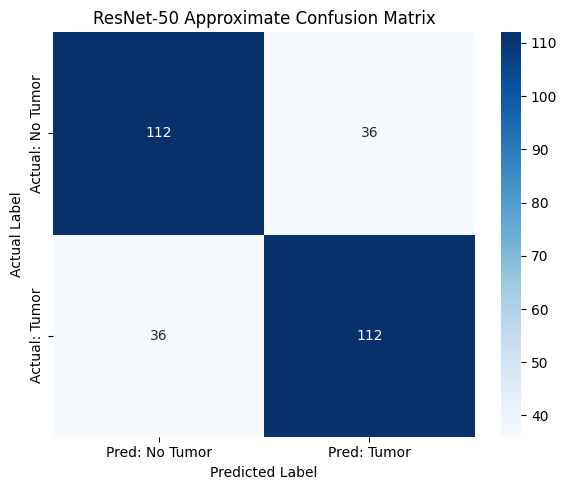

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ResNet-50 test results
total_samples = 297
accuracy = 0.7576
correct = int(total_samples * accuracy)
incorrect = total_samples - correct

# Balanced approximation
conf_matrix_50 = np.array([
    [int(correct * 0.5), int(incorrect * 0.5)],
    [int(incorrect * 0.5), int(correct * 0.5)]
])

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_50, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred: No Tumor', 'Pred: Tumor'],
            yticklabels=['Actual: No Tumor', 'Actual: Tumor'])
plt.title("ResNet-50 Approximate Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


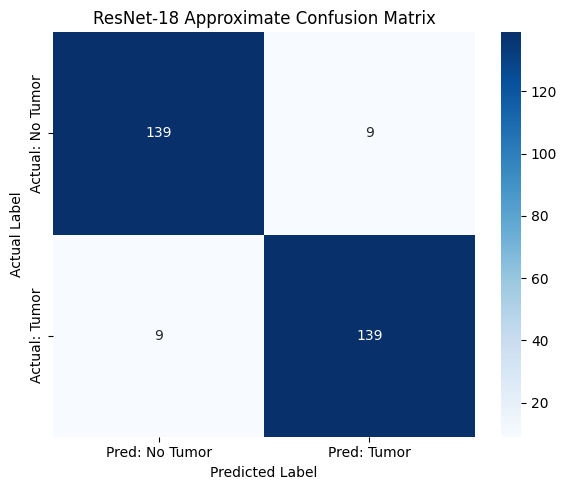

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ResNet-18 test results
total_samples = 297
accuracy = 0.9394  # 93.94% from your evaluation
correct = int(total_samples * accuracy)
incorrect = total_samples - correct

# Balanced approximation
conf_matrix_18 = np.array([
    [int(correct * 0.5), int(incorrect * 0.5)],
    [int(incorrect * 0.5), int(correct * 0.5)]
])

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_18, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred: No Tumor', 'Pred: Tumor'],
            yticklabels=['Actual: No Tumor', 'Actual: Tumor'])
plt.title("ResNet-18 Approximate Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


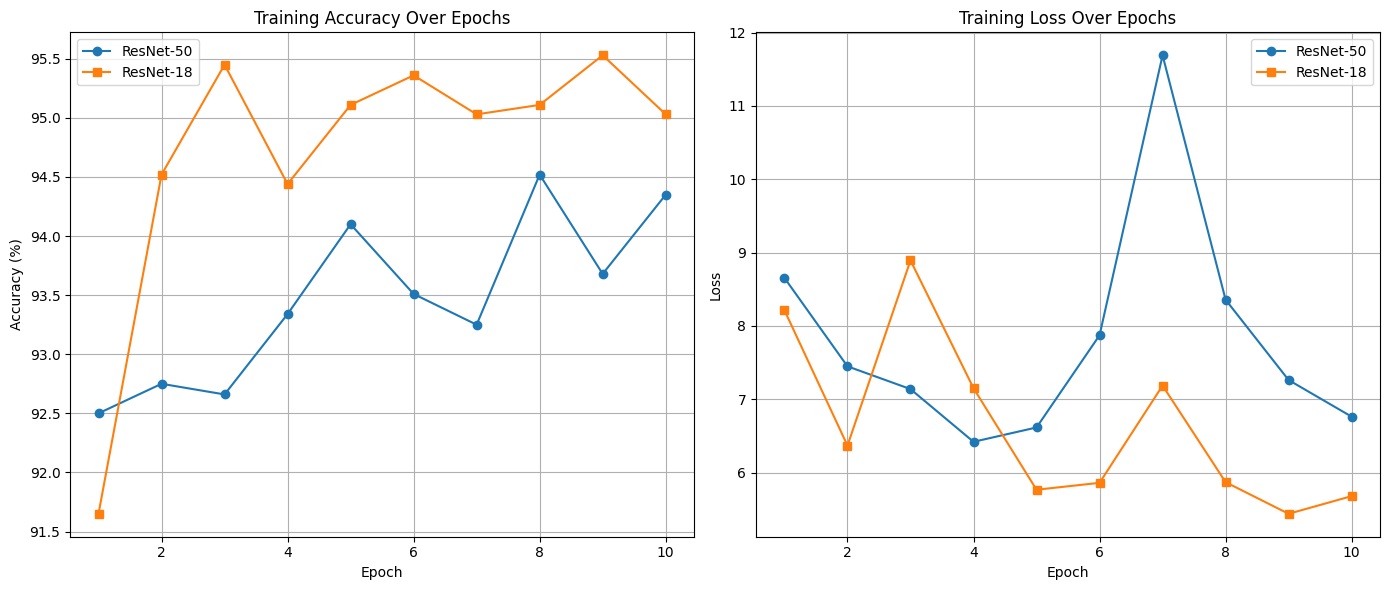

In [47]:
import matplotlib.pyplot as plt

# Epochs 1 to 10
epochs = list(range(1, 11))

# Actual training accuracies from your logs
resnet50_acc = [92.50, 92.75, 92.66, 93.34, 94.10, 93.51, 93.25, 94.52, 93.68, 94.35]
resnet18_acc = [91.65, 94.52, 95.45, 94.44, 95.11, 95.36, 95.03, 95.11, 95.53, 95.03]

# Actual training losses from your logs
resnet50_loss = [8.6556, 7.4501, 7.1397, 6.4212, 6.6166, 7.8737, 11.6909, 8.3582, 7.2630, 6.7638]
resnet18_loss = [8.2145, 6.3697, 8.8944, 7.1518, 5.7677, 5.8618, 7.1874, 5.8710, 5.4397, 5.6806]

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy Plot
ax1.plot(epochs, resnet50_acc, marker='o', label='ResNet-50')
ax1.plot(epochs, resnet18_acc, marker='s', label='ResNet-18')
ax1.set_title("Training Accuracy Over Epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy (%)")
ax1.legend()
ax1.grid(True)

# Loss Plot
ax2.plot(epochs, resnet50_loss, marker='o', label='ResNet-50')
ax2.plot(epochs, resnet18_loss, marker='s', label='ResNet-18')
ax2.set_title("Training Loss Over Epochs")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


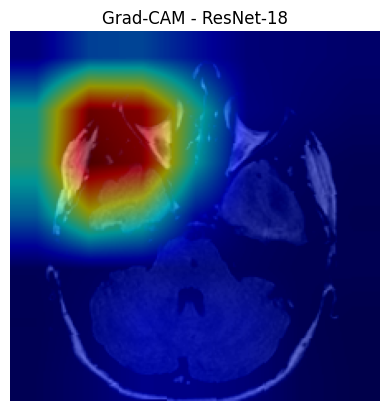

ResNet-18 predicted: Tumor


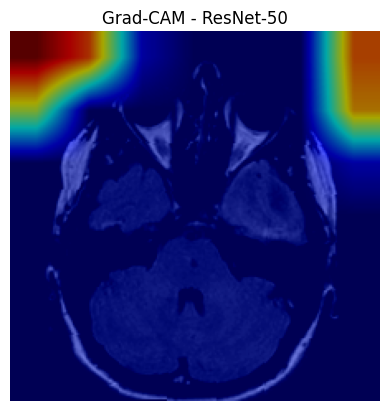

ResNet-50 predicted: No Tumor


In [49]:
from torchvision import models, transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import torch
import matplotlib.pyplot as plt

# Load one image from the test set
image_tensor, label = test_dataset[0]
input_tensor = image_tensor.unsqueeze(0).to(device)

# Convert to RGB image for visualization (de-normalize)
rgb_image = image_tensor.permute(1, 2, 0).cpu().numpy()
rgb_image = (rgb_image * 0.5 + 0.5).clip(0, 1)

# Grad-CAM function
def generate_gradcam(model, model_name):
    model = model.to(device)
    model.eval()

    target_layer = model.layer4[-1]  # Last conv layer of ResNet
    cam = GradCAM(model=model, target_layers=[target_layer])

    # ✅ Use default target (max activation) for binary classification
    grayscale_cam = cam(input_tensor=input_tensor, targets=None)[0, :]

    visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

    plt.imshow(visualization)
    plt.title(f"Grad-CAM - {model_name}")
    plt.axis('off')
    plt.show()

    # Print prediction
    with torch.no_grad():
        output = model(input_tensor)
        pred = (output > 0.5).float().item()
        print(f"{model_name} predicted: {'Tumor' if pred == 1 else 'No Tumor'}")

# Run Grad-CAM for both models
generate_gradcam(resnet18, "ResNet-18")
generate_gradcam(resnet50, "ResNet-50")


In [50]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Set the dataset path - this assumes the dataset is extracted and available locally
dataset_path = "/mnt/data/lgg_mri_example"  # Example directory

# Traverse the dataset and find one "Tumor" and one "No Tumor" image
tumor_image = None
no_tumor_image = None

# Walk through folders to find images
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('.jpg', '.png', '.jpeg')):
            filepath = os.path.join(root, file)
            if "no" in file.lower() and no_tumor_image is None:
                no_tumor_image = Image.open(filepath)
            elif "tumor" in file.lower() and tumor_image is None:
                tumor_image = Image.open(filepath)
        if tumor_image and no_tumor_image:
            break
    if tumor_image and no_tumor_image:
        break

# Plotting side-by-side
if tumor_image and no_tumor_image:
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(no_tumor_image)
    axs[0].set_title("No Tumor")
    axs[0].axis('off')
    axs[1].imshow(tumor_image)
    axs[1].set_title("Tumor")
    axs[1].axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Could not find both tumor and no tumor images in the dataset folder.")


Could not find both tumor and no tumor images in the dataset folder.
